In [78]:
import pandas as pd

# Update URL for direct download
url = "https://drive.google.com/uc?export=download&id=1SCYTPdDn1SWoUxTYHht4B04ejujYe07g"
data = pd.read_csv(url)

# Inspect data
print(data.head(4))


  state        date  critical_staffing_shortage_today_yes  \
0    MA  2021/06/15                                     6   
1    WY  2021/06/13                                     2   
2    LA  2021/06/06                                    41   
3    RI  2021/06/04                                     4   

   critical_staffing_shortage_today_no  \
0                                   72   
1                                   26   
2                                  176   
3                                    9   

   critical_staffing_shortage_today_not_reported  \
0                                              1   
1                                              2   
2                                              6   
3                                              2   

   critical_staffing_shortage_anticipated_within_week_yes  \
0                                                  6        
1                                                  3        
2                                      

In [9]:
# check the number of rows and columns
print(data.shape)

(81713, 135)


In [15]:
# check and optimize data types
for col in data.select_dtypes(include=['float64']).columns:
    data[col] = data[col].astype('float32')

for col in data.select_dtypes(include=['int64']).columns:
    data[col] = data[col].astype('int32')
    
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81713 entries, 0 to 81712
Columns: 135 entries, state to total_staffed_pediatric_icu_beds_coverage
dtypes: float32(77), int32(56), object(2)
memory usage: 42.7+ MB
None


In [17]:
print(data.columns)

Index(['state', 'date', 'critical_staffing_shortage_today_yes',
       'critical_staffing_shortage_today_no',
       'critical_staffing_shortage_today_not_reported',
       'critical_staffing_shortage_anticipated_within_week_yes',
       'critical_staffing_shortage_anticipated_within_week_no',
       'critical_staffing_shortage_anticipated_within_week_not_reported',
       'hospital_onset_covid', 'hospital_onset_covid_coverage',
       ...
       'previous_day_admission_pediatric_covid_confirmed_5_11',
       'previous_day_admission_pediatric_covid_confirmed_5_11_coverage',
       'previous_day_admission_pediatric_covid_confirmed_unknown',
       'previous_day_admission_pediatric_covid_confirmed_unknown_coverage',
       'staffed_icu_pediatric_patients_confirmed_covid',
       'staffed_icu_pediatric_patients_confirmed_covid_coverage',
       'staffed_pediatric_icu_bed_occupancy',
       'staffed_pediatric_icu_bed_occupancy_coverage',
       'total_staffed_pediatric_icu_beds',
       't

In [80]:
# Delete columns that contain more than 50% missing values
threshold = 0.5
data = data.dropna(axis=1, thresh=int((1-threshold) * len(data)))
# Delete rows that contain more than 50% missing values
data = data.dropna(axis=0, thresh=int((1-threshold) * len(data.columns)))
# check the data frame after deletion
print(data.info())
data.to_csv("cleaned_data.csv", index=False)

# Return to the place where current file was saved 
import os
print(os.getcwd())


<class 'pandas.core.frame.DataFrame'>
Index: 81449 entries, 0 to 81712
Columns: 134 entries, state to total_staffed_pediatric_icu_beds_coverage
dtypes: float64(76), int64(56), object(2)
memory usage: 83.9+ MB
None
C:\Users\boa


In [108]:
import pandas as pd

# Load the cleaned data
data = pd.read_csv("cleaned_data.csv")

# Convert the 'date' column to datetime format (replace 'Date' with the actual column name)
data['date'] = pd.to_datetime(data['date'])

# Sort the data by the date column
data_sorted = data.sort_values(by='date')

# Save the sorted data to a new file
data_sorted.to_csv("sorted_data.csv", index=False)

# Print the first few rows to confirm sorting
print(data_sorted.head())


      state       date  critical_staffing_shortage_today_yes  \
27703    HI 2020-01-01                                     0   
27053    IN 2020-01-01                                     0   
32436    TX 2020-01-01                                     0   
25809    MT 2020-01-01                                     0   
29697    PR 2020-01-01                                     0   

       critical_staffing_shortage_today_no  \
27703                                    0   
27053                                    0   
32436                                    0   
25809                                    0   
29697                                    0   

       critical_staffing_shortage_today_not_reported  \
27703                                              1   
27053                                              1   
32436                                              3   
25809                                              1   
29697                                              1   

 

## Hypothesis 1: Staffing shortages correlate with Inpatient bed occupancy.

#### Exploration: Investigate if states reporting critical staffing shortages also have higher ICU bed occupancy rates. Compare columns, such as critical_staffing_shortage_today_yes, inpatient_beds_used and inpatient_beds_utilization. 
#### Visualization: A correlation heatmap between staffing shortages and Inpatient bed occupancy.

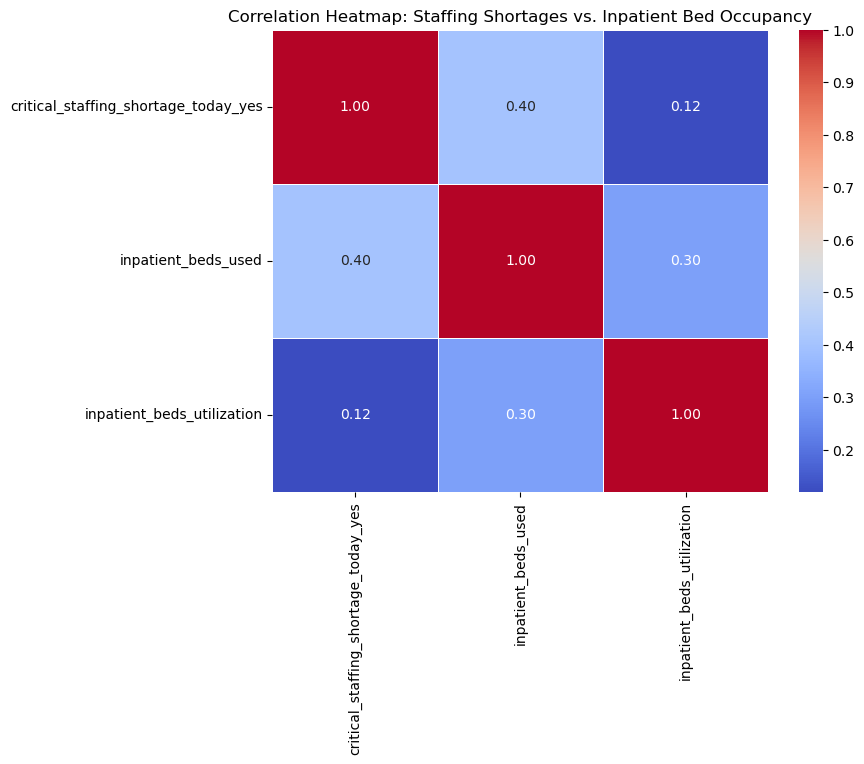

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn

# Select relevant columns for the heatmap
selected_columns = [
    'critical_staffing_shortage_today_yes',
    'inpatient_beds_used',
    'inpatient_beds_utilization'
]

# Drop rows with missing values in the selected columns
heatmap_data = data[selected_columns].dropna()

# Compute the correlation matrix
correlation_matrix = heatmap_data.corr()

# Generate the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Staffing Shortages vs. Inpatient Bed Occupancy")
plt.show()


#### Conclusion 1: Staffing shortages weakly correlate with Inpatient bed occupancy.

## Hypothesis 2: Adult COVID-19 hospital admissions increase ICU bed usage.

#### Exploration: Look at the relationship between adult COVID-19 admissions (previous_day_admission_adult_covid_confirmed) and the total adult ICU bed occupancy (staffed_adult_icu_bed_occupancy).
#### Visualization: creat a conbined line chart to show how admissions and ICU bed usage trend over time.

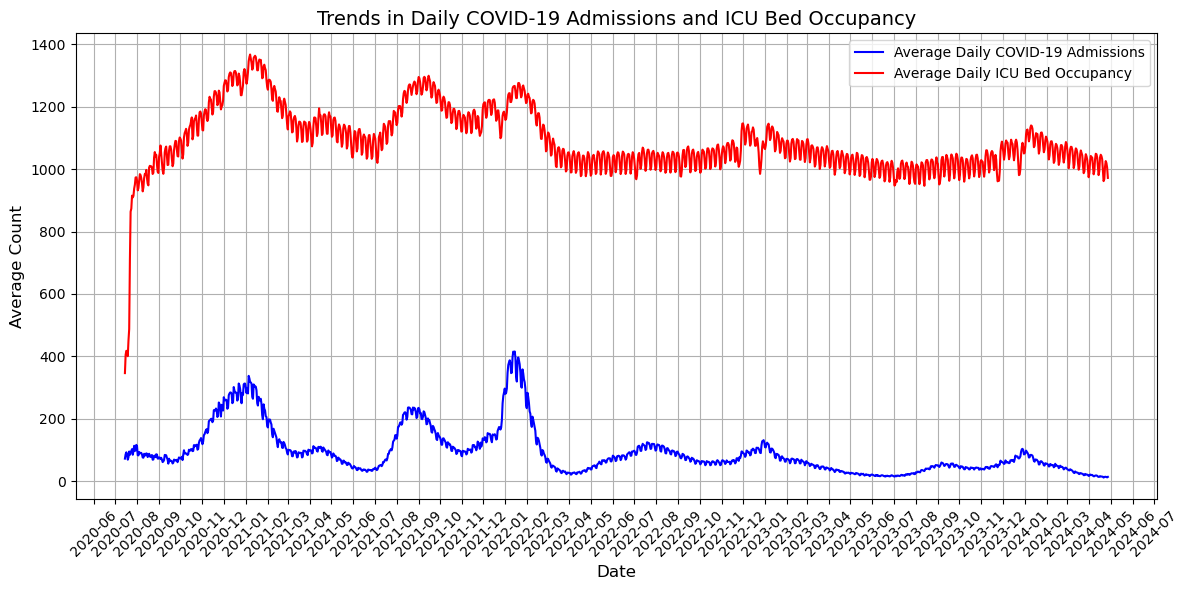

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the sorted data
df = pd.read_csv("sorted_data.csv")

# choose specific columns
df = df[['date', 'previous_day_admission_adult_covid_confirmed', 'staffed_adult_icu_bed_occupancy']]

# delete rows before 2020-07-15 due to too many missing values
df = df[df['date'] >= '2020-07-15']

# Group by 'date' and calculate the average for each day
daily_avg = df.groupby('date')[['previous_day_admission_adult_covid_confirmed', 'staffed_adult_icu_bed_occupancy']].mean().reset_index()

# Convert 'date' column to datetime if it isn't already
daily_avg['date'] = pd.to_datetime(daily_avg['date'])

# Plot a combined line chart
plt.figure(figsize=(12, 6))

# Plotting adult COVID-19 admissions
plt.plot(daily_avg['date'], daily_avg['previous_day_admission_adult_covid_confirmed'], label='Average Daily COVID-19 Admissions', color='blue')

# Plotting ICU bed occupancy
plt.plot(daily_avg['date'], daily_avg['staffed_adult_icu_bed_occupancy'], label='Average Daily ICU Bed Occupancy', color='red')

# Adding titles and labels
plt.title('Trends in Daily COVID-19 Admissions and ICU Bed Occupancy', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Count', fontsize=12)

# Set X-axis to display by month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to be monthly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format the date as Year-Month

# Rotate the X-axis labels to make them readable
plt.xticks(rotation=45)

# Display a legend
plt.legend()

# Remove gridlines if not needed
plt.grid(True)

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


In [116]:
# calculate the correlation
correlation = daily_avg['previous_day_admission_adult_covid_confirmed'].corr(
    daily_avg['staffed_adult_icu_bed_occupancy']
)
print(f"Correlation between adult COVID-19 admissions and adult ICU bed occupancy: {correlation:.2f}")

Correlation between adult COVID-19 admissions and adult ICU bed occupancy: 0.73


#### Conclusion 2: There is a strong positive correlation between adult COVID-19 admissions and the total adult ICU bed occupancy.

## A choropleth map (saved as Html format) to visualize the trend of Adult COVID-19 Admissions across US states (2020-2024).

In [118]:
import pandas as pd

# Load the sorted data
df = pd.read_csv("sorted_data.csv")

# Select necessary columns
df_cm = df[['state', 'date', 'previous_day_admission_adult_covid_confirmed']]

# Delete rows where the date is before 2020-07-15
df_cm = df_cm[df_cm['date'] >= '2020-07-15']

# Step 1: Data Cleaning
# Fill missing values in 'previous_day_admission_adult_covid_confirmed' with 0
df_cm['previous_day_admission_adult_covid_confirmed'] = df_cm['previous_day_admission_adult_covid_confirmed'].fillna(0)

# Verify the cleaned dataset
print(df_cm.info())
print(df_cm.head())

# Save the cleaned df_cm to a CSV file
df_cm.to_csv("CMap_data.csv", index=False)

print("Data saved to CMap_data.csv")


<class 'pandas.core.frame.DataFrame'>
Index: 74271 entries, 7178 to 81448
Data columns (total 3 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   state                                         74271 non-null  object 
 1   date                                          74271 non-null  object 
 2   previous_day_admission_adult_covid_confirmed  74271 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.3+ MB
None
     state        date  previous_day_admission_adult_covid_confirmed
7178    SC  2020-07-15                                         103.0
7179    NC  2020-07-15                                          87.0
7180    OK  2020-07-15                                          48.0
7181    ME  2020-07-15                                           0.0
7182    CA  2020-07-15                                         449.0
Data saved to CMap_data.csv


In [120]:
import pandas as pd

# Load the dataset
data = pd.read_csv("CMap_data.csv")

# Define the mapping of state abbreviations to full names
state_mapping = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming',
    'DC': 'District of Columbia'
}

# Map state abbreviations to full names
data['state_full'] = data['state'].map(state_mapping)

# Check for unmapped states
unmapped_states = data[data['state_full'].isna()]['state'].unique()

print(data.head())
print("Unmapped states/territories:", unmapped_states)


  state        date  previous_day_admission_adult_covid_confirmed  \
0    SC  2020-07-15                                         103.0   
1    NC  2020-07-15                                          87.0   
2    OK  2020-07-15                                          48.0   
3    ME  2020-07-15                                           0.0   
4    CA  2020-07-15                                         449.0   

       state_full  
0  South Carolina  
1  North Carolina  
2        Oklahoma  
3           Maine  
4      California  
Unmapped states/territories: ['VI' 'AS']


In [124]:
# Exclude rows with territories not in GeoJSON
data_cleaned = data[~data['state'].isin(['VI', 'AS'])]

# Save the cleaned data to a CSV file
data_cleaned.to_csv('CMap_data_cleaned.csv', index=False)

In [126]:
print(data_cleaned['state_full'].unique())


['South Carolina' 'North Carolina' 'Oklahoma' 'Maine' 'California'
 'Connecticut' 'Nebraska' 'Rhode Island' 'Arizona' 'Colorado' 'Washington'
 'Alaska' 'New Jersey' 'Idaho' 'Delaware' 'New Hampshire' 'Puerto Rico'
 'District of Columbia' 'Iowa' 'Kansas' 'Kentucky' 'Massachusetts'
 'Missouri' 'Maryland' 'Minnesota' 'Texas' 'Montana' 'Hawaii' 'Wisconsin'
 'Tennessee' 'Oregon' 'Vermont' 'West Virginia' 'Pennsylvania'
 'South Dakota' 'Nevada' 'Arkansas' 'Indiana' 'Wyoming' 'Alabama'
 'Illinois' 'Georgia' 'New Mexico' 'North Dakota' 'Florida' 'Mississippi'
 'Virginia' 'New York' 'Ohio' 'Michigan' 'Utah' 'Louisiana']


In [128]:
import json
with open('us-states.json', 'r') as f:
    geojson_data = json.load(f)
print([feature['properties']['name'] for feature in geojson_data['features']])


['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming', 'Puerto Rico']


In [130]:
import pandas as pd

# load the data
df = pd.read_csv('CMap_data_cleaned.csv')

#  confirm the date is in date format
df['date'] = pd.to_datetime(df['date'])

# extract the year
df['year'] = df['date'].dt.year

# map the Abbreviation to it state full name
state_mapping = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 
    'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia',
    'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 
    'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 
    'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 
    'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 
    'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

df['state_full'] = df['state'].map(state_mapping)

# grouped by state and year, calculate average daily admissions
avg_admissions = df.groupby(['state', 'state_full', 'year'])['previous_day_admission_adult_covid_confirmed'].mean().reset_index()

# rename columns
avg_admissions.rename(columns={'previous_day_admission_adult_covid_confirmed': 'avg_daily_admission'}, inplace=True)

# display the result
print(avg_admissions.head())

# Save the result to a new CSV file
avg_admissions.to_csv("average_admissions_per_year.csv", index=False)

print("Result saved as average_admissions_per_year.csv")




  state state_full  year  avg_daily_admission
0    AK     Alaska  2020             8.682353
1    AK     Alaska  2021            10.235616
2    AK     Alaska  2022             8.493151
3    AK     Alaska  2023             3.717808
4    AK     Alaska  2024             3.398305
Result saved as average_admissions_per_year.csv


In [160]:
df = pd.read_csv('average_admissions_per_year.csv')

import plotly.express as px

# create a Choropleth Map
fig = px.choropleth(
    df,
    locations="state",                # State Code
    locationmode="USA-states",        # U.S. state abbreviations
    color="avg_daily_admission",      # Displayed value
    hover_name="state_full",          # Hover to display the full state name
    animation_frame="year",           # Animation year
    title="Trend of Adult COVID-19 Admissions Across US States (2020-2024)",
    color_continuous_scale="Reds",    # color gradient
    scope="usa"                       
)

# Save as HTML file
fig.write_html("covid_admissions_trend.html")

print("Map saved as covid_admissions_trend.html")


Map saved as covid_admissions_trend.html


## Track trends in admissions for each age group over years (2020-2024).

In [135]:
import pandas as pd

# Load the uploaded data
df = pd.read_csv('sorted_data.csv')

# Step 1: Select specific columns
columns_to_select = [
    'state', 'date', 
    'previous_day_admission_adult_covid_confirmed_20-29',
    'previous_day_admission_adult_covid_confirmed_30-39',
    'previous_day_admission_adult_covid_confirmed_40-49',
    'previous_day_admission_adult_covid_confirmed_50-59',
    'previous_day_admission_adult_covid_confirmed_60-69',
    'previous_day_admission_adult_covid_confirmed_70-79',
    'previous_day_admission_adult_covid_confirmed_80+'
]
df_selected = df[columns_to_select]

# Step 2: Remove rows with dates before 2020-07-22 due to too many missing values
df_filtered = df_selected[df_selected['date'] >= '2020-07-22']

# Replace missing values (NaN) with 0
df_filled = df_filtered.fillna(0)

print(df_filled.head(4))

df_filled.to_csv("filtered.csv", index=False)

     state        date  previous_day_admission_adult_covid_confirmed_20-29  \
7543    WY  2020-07-22                                                0.0    
7544    MT  2020-07-22                                                1.0    
7545    IA  2020-07-22                                                0.0    
7546    CT  2020-07-22                                                0.0    

      previous_day_admission_adult_covid_confirmed_30-39  \
7543                                                0.0    
7544                                                1.0    
7545                                                0.0    
7546                                                0.0    

      previous_day_admission_adult_covid_confirmed_40-49  \
7543                                                0.0    
7544                                                1.0    
7545                                                0.0    
7546                                                1.0    

      p

In [137]:
# Drop the 'state' column
data = df_filled.drop(columns=['state'])

# Group by date and sum all admission columns
summary = data.groupby('date').sum()

# Save the summarized data to a CSV file
summary.reset_index().to_csv('summarized_data.csv', index=False)

# Display the first few rows of the summarized data
summary.reset_index().head()


,date,previous_day_admission_adult_covid_confirmed_20-29,previous_day_admission_adult_covid_confirmed_30-39,previous_day_admission_adult_covid_confirmed_40-49,previous_day_admission_adult_covid_confirmed_50-59,previous_day_admission_adult_covid_confirmed_60-69,previous_day_admission_adult_covid_confirmed_70-79,previous_day_admission_adult_covid_confirmed_80+
0,2020-07-22,161.0,207.0,293.0,439.0,575.0,479.0,423.0
1,2020-07-23,231.0,347.0,444.0,682.0,819.0,772.0,710.0
2,2020-07-24,214.0,309.0,455.0,732.0,816.0,747.0,675.0
3,2020-07-25,243.0,325.0,443.0,717.0,866.0,822.0,659.0
4,2020-07-26,179.0,293.0,410.0,664.0,800.0,798.0,613.0


In [141]:
import pandas as pd
df = pd.read_csv('summarized_data.csv')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year  # Extract the year

age_groups = [
    'previous_day_admission_adult_covid_confirmed_20-29',
    'previous_day_admission_adult_covid_confirmed_30-39',
    'previous_day_admission_adult_covid_confirmed_40-49',
    'previous_day_admission_adult_covid_confirmed_50-59',
    'previous_day_admission_adult_covid_confirmed_60-69',
    'previous_day_admission_adult_covid_confirmed_70-79',
    'previous_day_admission_adult_covid_confirmed_80+'
]

# calculate the daily average for each age group by year
avg_admissions_by_age = df.groupby('year')[age_groups].mean().reset_index()

# show the result
print(avg_admissions_by_age)


   year  previous_day_admission_adult_covid_confirmed_20-29  \
0  2020                                         285.398773    
1  2021                                         377.649315    
2  2022                                         333.594521    
3  2023                                          91.364384    
4  2024                                          78.457627    

   previous_day_admission_adult_covid_confirmed_30-39  \
0                                         423.791411    
1                                         597.328767    
2                                         419.227397    
3                                         122.819178    
4                                         115.042373    

   previous_day_admission_adult_covid_confirmed_40-49  \
0                                         614.533742    
1                                         766.356164    
2                                         386.772603    
3                                         129.1863

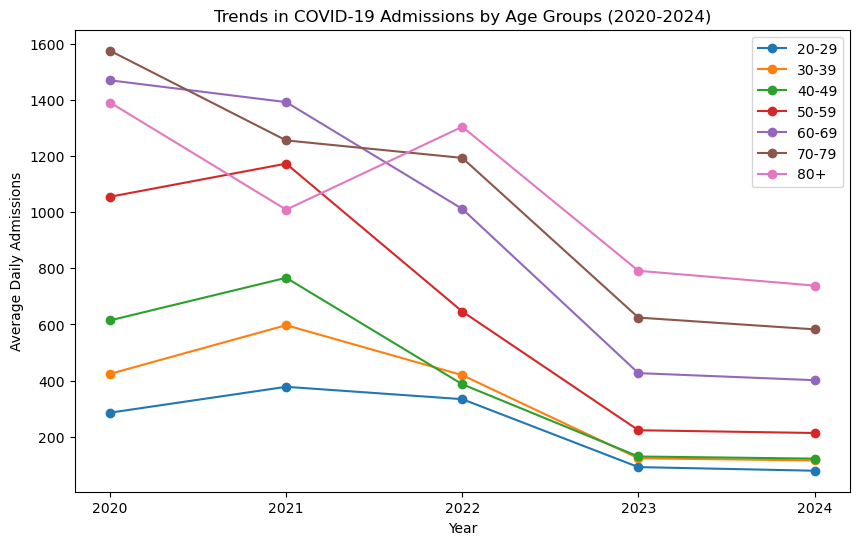

In [162]:
import pandas as pd
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot each age group trend using the 'avg_admissions_by_age' DataFrame
plt.plot(avg_admissions_by_age['year'], avg_admissions_by_age['previous_day_admission_adult_covid_confirmed_20-29'], label='20-29', marker='o')
plt.plot(avg_admissions_by_age['year'], avg_admissions_by_age['previous_day_admission_adult_covid_confirmed_30-39'], label='30-39', marker='o')
plt.plot(avg_admissions_by_age['year'], avg_admissions_by_age['previous_day_admission_adult_covid_confirmed_40-49'], label='40-49', marker='o')
plt.plot(avg_admissions_by_age['year'], avg_admissions_by_age['previous_day_admission_adult_covid_confirmed_50-59'], label='50-59', marker='o')
plt.plot(avg_admissions_by_age['year'], avg_admissions_by_age['previous_day_admission_adult_covid_confirmed_60-69'], label='60-69', marker='o')
plt.plot(avg_admissions_by_age['year'], avg_admissions_by_age['previous_day_admission_adult_covid_confirmed_70-79'], label='70-79', marker='o')
plt.plot(avg_admissions_by_age['year'], avg_admissions_by_age['previous_day_admission_adult_covid_confirmed_80+'], label='80+', marker='o')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Average Daily Admissions')
plt.title('Trends in COVID-19 Admissions by Age Groups (2020-2024)')

# Set X-axis ticks to only show integers (years)
plt.xticks(avg_admissions_by_age['year'])

# Display a legend
plt.legend()

# Show the plot
plt.grid(False)
plt.show()


#### Conclusion 4: 
#### The trends in admissions for each age group show an overall decline in the number of admissions from 2020 to 2024. Additionally, the number of admissions for individuals aged 60 and above is significantly higher than that of younger age groups.